In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
mpl.rcParams['figure.figsize'] = (10, 8)

In [2]:
N = 101
x = np.linspace(0, 1, N).reshape(-1, 1)

In [3]:
a = 0.2
K = np.exp(-(x-x.T)**2/a**2) + np.eye(N)*0.00001

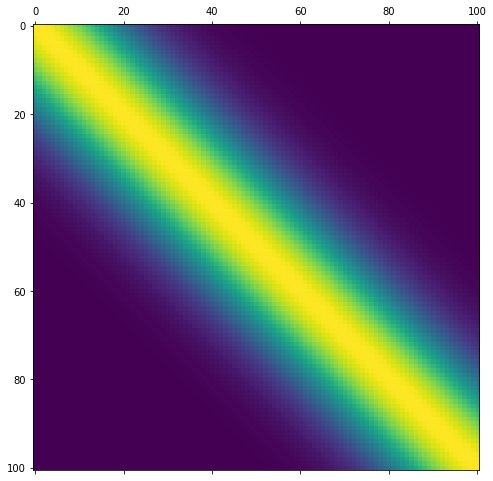

In [4]:
_ = plt.matshow(K)

In [5]:
L = np.linalg.cholesky(K)

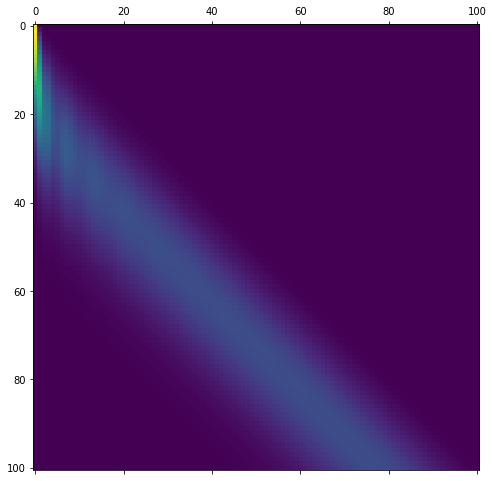

In [6]:
_ = plt.matshow(L)

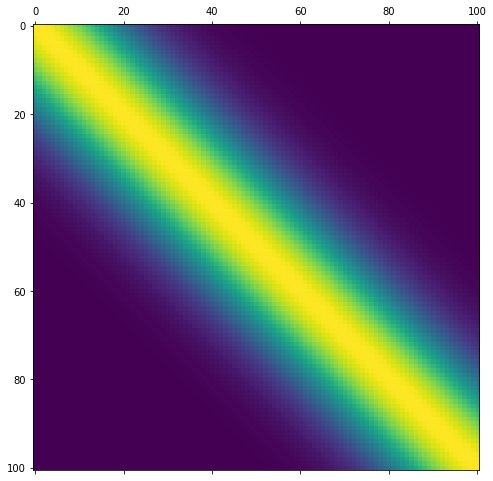

In [7]:
_ = plt.matshow(L.dot(L.T))

Sample from the Gaussian Process by use of the Cholesky decomposition of the Kernel matrix

In [8]:
n_sample = 50000
u = np.random.randn(N, n_sample)

In [9]:
f = L.dot(u)

In [88]:
def plot_gp(x, f, n_plot=None):
    _ = plt.plot(x, f[:, np.random.permutation(f.shape[1])[:n_plot]], c='k', alpha=0.05)
    _ = plt.plot(x, f.mean(axis=1), c='b', linewidth=2)
    _ = plt.plot(x, f.mean(axis=1) + 2*f.std(axis=1), c='r', linewidth=2)
    _ = plt.plot(x, f.mean(axis=1) + -2*f.std(axis=1), c='r', linewidth=2)

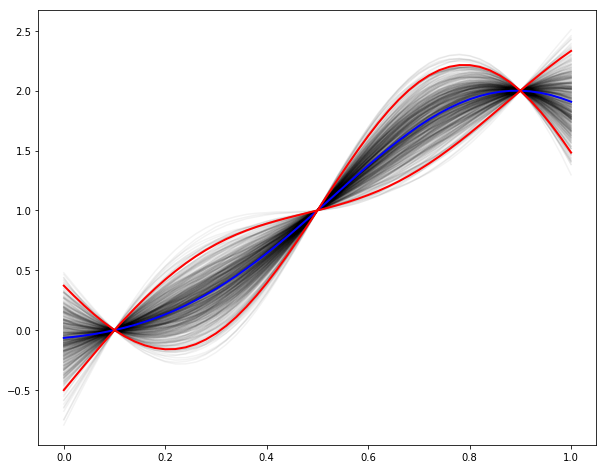

In [89]:
plot_gp(x, f, 500)

Sample from the posterior given points at (0.1, 0.0), (0.5, 1.0)

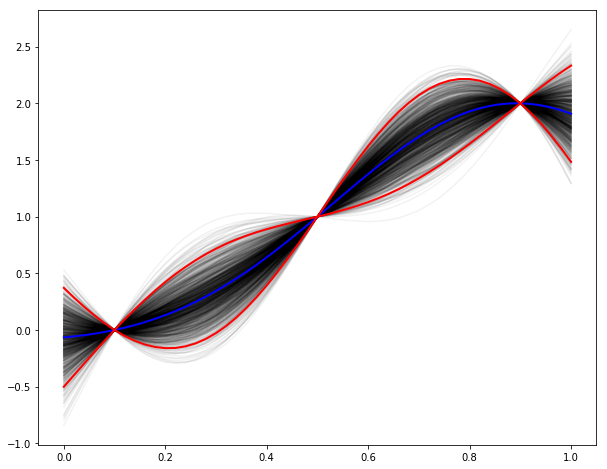

In [90]:
plot_gp(x, f[:, (np.abs(f[np.where(x == 0.1)[0][0], :] - 0.0) < 0.05) &
                  (np.abs(f[np.where(x == 0.5)[0][0], :] -1) < 0.05)])

Following above, create a function for sampling from Gaussian Process with squared exponential kernel

In [91]:
def sample_gp(a=0.2, n=101, n_sample=50000):
    x = np.linspace(0, 1, n).reshape(-1, 1)
    K = np.exp(-(x-x.T)**2/a**2) + np.eye(n)*0.00001
    L = np.linalg.cholesky(K)
    u = np.random.randn(n, n_sample)
    f = L.dot(u)
    return x, f

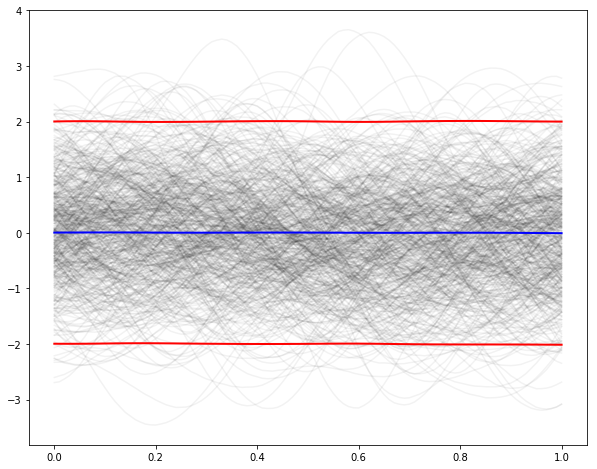

In [92]:
plot_gp(*sample_gp(), n_plot=500)

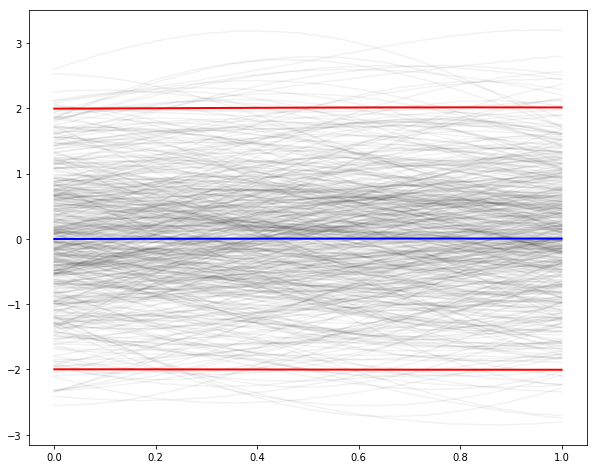

In [93]:
plot_gp(*sample_gp(a=1), n_plot=500)

In [96]:
def sample_gp_posterior(data=None, a=0.2, n=101, n_sample=50000):
    # data is list of (x, f(x)) tuples
    x_d, f_d = zip(*data)    
    x = np.linspace(0, 1, n).reshape(-1, 1)
    x_d = np.array(x_d).reshape(-1, 1)
    f_d = np.array(f_d).reshape(-1, 1)
    # Remove data points from test points
    x_t = x[~np.in1d(x, x_d)]
    
    def kernel(x1, x2, sigma_n=1e-6):
        k = np.exp(-(x1-x2.T)**2/a**2)
        if len(x1) == len(x2):
            return k + np.eye(len(x1))*sigma_n
        else:
            return k
    
    K_d_inv = np.linalg.inv(kernel(x_d, x_d))
    K_t_d = kernel(x_t, x_d, 0)
    K_t_t = kernel(x_t, x_t, 1e-6) 
    
    # Mean and Variance of posterior
    f_t_mu = K_t_d.dot(K_d_inv).dot(f_d)
    f_t_var = K_t_t - K_t_d.dot(K_d_inv).dot(K_t_d.T)
    
    # Sample from posterior
    L = np.linalg.cholesky(f_t_var)
    u = np.random.randn(len(x_t), n_sample)
    f_t = f_t_mu + L.dot(u)    
    
    # Concatenate data and posterior
    x = np.vstack([x_d, x_t])
    f = np.vstack([np.tile(f_d, (1, f_t.shape[1])), f_t])
    # Reorder for plotting
    ind = np.argsort(x, axis=0).flatten()
    x = x[ind,:]
    f = f[ind, :]
    return x, f

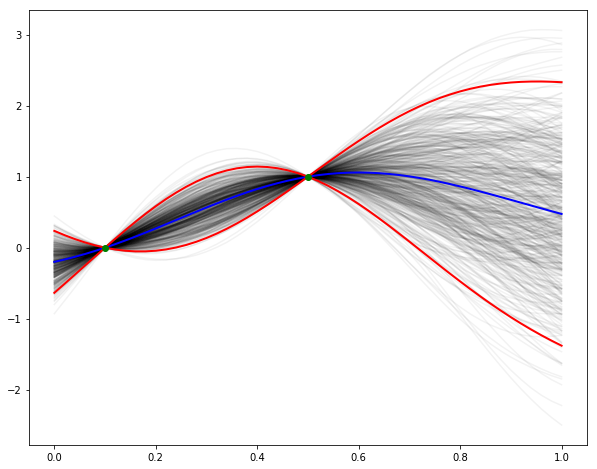

In [98]:
data = [(0.1, 0.0), (0.5, 1.0)]
x_d, f_d = zip(*data)
x, f = sample_gp_posterior(data=data, a=0.5, n=51, n_sample=1000)
plot_gp(x, f, 500)
_ = plt.plot(x_d, f_d, linestyle='none', marker='o', c='g', markersize=6)